In [1]:
# !pip3 install bayesian-optimization

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn import metrics as skmetrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from bayes_opt import BayesianOptimization

In [25]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200
sns.set(rc={'figure.figsize':(5,10)})


In [26]:
X_smote = pd.read_csv('data/X_smote.csv')
y_smote = pd.read_csv('data/y_smote.csv')

X_val = pd.read_csv('data/X_val.csv')
y_val = pd.read_csv('data/y_val.csv')

X_test = pd.read_csv('data/X_test.csv')
y_test = pd.read_csv('data/y_test.csv')

In [27]:
def print_statistics(y_actual, y_pred, y_pred_prob, dataset_type):
  print(f"====================={dataset_type}====================")
  print(f"accuracy: {round(skmetrics.accuracy_score(y_actual, y_pred),5)}")
  print(f"precision: {round(skmetrics.precision_score(y_actual, y_pred),5)}")
  print(f"recall: {round(skmetrics.recall_score(y_actual, y_pred),5)}")
  print(f"f1 score: {round(skmetrics.f1_score(y_actual, y_pred),5)}")
  prec, recall, thresholds = skmetrics.precision_recall_curve(y_actual, y_pred_prob)
  print(f'pr auc: {round(skmetrics.auc(recall, prec), 5)}')


## Random Forest

In [28]:
rf = RandomForestClassifier()
rf_model = rf.fit(X_smote, y_smote)

y_pred_train = rf_model.predict(X_smote)
y_pred_train_proba = rf_model.predict_proba(X_smote)[:, 1]
print_statistics(y_smote, y_pred_train, y_pred_train_proba, 'train')

y_pred_val = rf_model.predict(X_val)
y_pred_val_proba = rf_model.predict_proba(X_val)[:, 1]
print_statistics(y_val, y_pred_val, y_pred_val_proba, 'val')

y_pred_test = rf_model.predict(X_test)
y_pred_test_proba = rf_model.predict_proba(X_test)[:, 1]
print_statistics(y_test, y_pred_test, y_pred_test_proba, 'test')

/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2399065869.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model = rf.fit(X_smote, y_smote)


=====================train====================
accuracy: 1.0
precision: 1.0
recall: 1.0
f1 score: 1.0
pr auc: 1.0
=====================val====================
accuracy: 0.92329
precision: 0.93721
recall: 0.76735
f1 score: 0.84382
pr auc: 0.85048
=====================test====================
accuracy: 0.92746
precision: 0.92148
recall: 0.79949
f1 score: 0.85616
pr auc: 0.87201


## Extra Trees Classifier

In [29]:
xtc = ExtraTreesClassifier()
xtc_model = xtc.fit(X_smote, y_smote)

y_pred_train = xtc_model.predict(X_smote)
y_pred_train_proba = xtc_model.predict_proba(X_smote)[:, 1]
print_statistics(y_smote, y_pred_train, y_pred_train_proba, 'train')

y_pred_val = xtc_model.predict(X_val)
y_pred_val_proba = xtc_model.predict_proba(X_val)[:, 1]
print_statistics(y_val, y_pred_val, y_pred_val_proba, 'val')

y_pred_test = xtc_model.predict(X_test)
y_pred_test_proba = xtc_model.predict_proba(X_test)[:, 1]
print_statistics(y_test, y_pred_test, y_pred_test_proba, 'test')

/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/433721700.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


=====================train====================
accuracy: 1.0
precision: 1.0
recall: 1.0
f1 score: 1.0
pr auc: 1.0
=====================val====================
accuracy: 0.92086
precision: 0.92969
recall: 0.76478
f1 score: 0.83921
pr auc: 0.8595
=====================test====================
accuracy: 0.91114
precision: 0.8827
recall: 0.77378
f1 score: 0.82466
pr auc: 0.86764


## Tune the ExtraTrees classifier

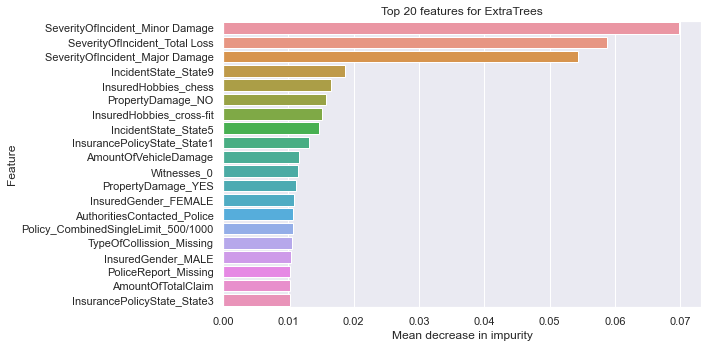

In [50]:
feature_names = [f"{X_smote.columns[i]}" for i in range(X_smote.shape[1])]

importances = xtc_model.feature_importances_

forest_importances = pd.DataFrame({'feature': feature_names,
                                    'importance': importances}
                                    )
forest_importances = forest_importances.sort_values('importance', ascending=False)
forest_importances = forest_importances[:20] # top 20

fig, ax = plt.subplots(1,1)
sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(y='feature', x='importance', ax=ax, data=forest_importances, orient="h")
ax.set_title("Top 20 features for ExtraTrees")
ax.set_xlabel("Mean decrease in impurity")
ax.set_ylabel("Feature")
fig.tight_layout()

## Bayesian optimization of ExtraTrees for hyperparameter tuning

In [54]:
seed = 1

def extratrees(n_estimators,
                max_depth,
                min_samples_split,
                min_samples_leaf,
                max_features,
                bootstrap):

    n_estimators = int(n_estimators)
    max_depth = int(max_depth) # Pre-pruning technique
    min_samples_split = int(min_samples_split) # Pre-pruning technique
    min_samples_leaf = int(min_samples_leaf) # Pre-pruning technique
    bootstrap = bootstrap > 0.5
    
    assert type(n_estimators) == int
    assert type(max_depth) == int
    assert type(min_samples_split) == int
    assert type(min_samples_leaf) == int


    xtc = ExtraTreesClassifier(n_estimators=n_estimators,
                               max_depth=max_depth,
                               min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               max_features=max_features,
                               bootstrap=bootstrap,
                               oob_score=bootstrap,
                               n_jobs=6,
                               random_state=seed,
                               verbose=0)

    xtc_model = xtc.fit(X_smote, y_smote)
    # use validation set to evaluate performance - F1 is our main metric
    y_pred_val = xtc_model.predict(X_val)
    return skmetrics.f1_score(y_val, y_pred_val)

In [65]:
# space to search
# params = {'n_estimators': (25, 251),
params = {'n_estimators': (25, 150),
          'max_depth' : (10, 200),
          'min_samples_split': (2,15),
          'min_samples_leaf' : (2,15),
          'max_features' : (.2,.8),
          'bootstrap':(0,1),
          } 

xtcBO = BayesianOptimization(extratrees, 
                            pbounds = params, 
                            random_state = seed)

print(xtcBO.space.keys)

['bootstrap', 'max_depth', 'max_features', 'min_samples_leaf', 'min_samples_split', 'n_estimators']


In [66]:
xtcBO.maximize(init_points=6, 
               n_iter=25,
               acq = 'ucb',
               xi = 0.0,
               alpha = 1e-6)

|   iter    |  target   | bootstrap | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 1         | 0.8165    | 0.417     | 146.9     | 0.2001    | 5.93      | 3.908     | 36.54     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 2         | 0.8017    | 0.1863    | 75.66     | 0.4381    | 9.005     | 7.45      | 110.7     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 3         | 0.7992    | 0.2045    | 176.8     | 0.2164    | 10.72     | 7.425     | 94.84     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 4         | 0.7797    | 0.1404    | 47.64     | 0.6804    | 14.59     | 6.075     | 111.5     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 5         | 0.8204    | 0.8764    | 180.0     | 0.251     | 2.508     | 4.208     | 134.8     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 6         | 0.7797    | 0.09835   | 90.01     | 0.7747    | 8.931     | 10.99     | 64.44     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 7         | 0.8157    | 0.3821    | 178.8     | 0.6073    | 2.65      | 5.49      | 136.2     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 8         | 0.8129    | 1.0       | 189.2     | 0.2       | 3.208     | 2.0       | 127.3     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 9         | 0.805     | 0.5282    | 173.3     | 0.5894    | 5.186     | 3.822     | 121.6     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 10        | 0.7863    | 0.5612    | 187.5     | 0.5671    | 10.27     | 4.209     | 139.0     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 11        | 0.8249    | 1.0       | 181.3     | 0.2       | 2.0       | 7.432     | 128.5     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 12        | 0.8079    | 1.0       | 186.6     | 0.2       | 2.0       | 15.0      | 122.5     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 13        | 0.8087    | 0.05911   | 152.9     | 0.6605    | 2.489     | 10.6      | 28.48     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 14        | 0.7967    | 0.1454    | 154.1     | 0.5867    | 8.485     | 7.198     | 45.87     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 15        | 0.8223    | 1.0       | 178.9     | 0.2       | 2.0       | 2.0       | 128.5     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 16        | 0.8104    | 0.8328    | 136.4     | 0.2       | 3.102     | 2.0       | 29.92     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 17        | 0.7804    | 0.3202    | 142.0     | 0.2868    | 14.97     | 10.07     | 29.78     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 18        | 0.8198    | 0.3479    | 138.9     | 0.2       | 2.0       | 2.0       | 43.0      |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 19        | 0.8106    | 1.0       | 126.3     | 0.2       | 2.0       | 2.0       | 45.78     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 20        | 0.8053    | 0.273     | 134.9     | 0.5802    | 7.867     | 2.699     | 57.61     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 21        | 0.809     | 1.0       | 136.7     | 0.2       | 2.0       | 13.09     | 43.57     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 22        | 0.8014    | 0.0       | 113.7     | 0.8       | 2.0       | 2.0       | 29.65     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 23        | 0.8138    | 0.6781    | 169.8     | 0.2635    | 2.499     | 12.22     | 129.9     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 24        | 0.8161    | 1.0       | 154.6     | 0.2       | 2.0       | 8.659     | 137.7     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 25        | 0.8131    | 0.4259    | 147.1     | 0.4828    | 5.118     | 12.94     | 128.1     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 26        | 0.7714    | 0.6478    | 155.3     | 0.7365    | 14.56     | 12.39     | 139.5     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 27        | 0.8229    | 0.08065   | 156.5     | 0.4312    | 3.494     | 4.595     | 128.0     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 28        | 0.822     | 1.0       | 147.7     | 0.2       | 2.0       | 2.0       | 130.4     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 29        | 0.8231    | 1.0       | 149.8     | 0.2       | 2.0       | 2.0       | 118.4     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 30        | 0.8232    | 0.0       | 136.4     | 0.2       | 2.0       | 2.0       | 119.2     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 31        | 0.8132    | 0.6343    | 140.5     | 0.2864    | 2.0       | 10.81     | 109.6     |


In [67]:
# Best Hyperparameters selected
xtcBO.max

{'target': 0.8248587570621468,
 'params': {'bootstrap': 1.0,
  'max_depth': 181.3405773630045,
  'max_features': 0.2,
  'min_samples_leaf': 2.0,
  'min_samples_split': 7.431592798064626,
  'n_estimators': 128.45847901642233}}

In [68]:
xtc_tuned = ExtraTreesClassifier(n_estimators = int(xtcBO.max['params']['n_estimators']),
                                    max_depth = int(xtcBO.max['params']['max_depth']),
                                    min_samples_split = int(xtcBO.max['params']['min_samples_split']),  
                                    min_samples_leaf = int(xtcBO.max['params']['min_samples_leaf']),
                                    max_features =  xtcBO.max['params']['max_features'],                 
                                    bootstrap = xtcBO.max['params']['bootstrap'] > 0.5,
                                    oob_score = xtcBO.max['params']['bootstrap'] > 0.5,
                                    n_jobs=6)

xtc_tuned_model = xtc_tuned.fit(X_smote, y_smote)

y_pred_train = xtc_tuned_model.predict(X_smote)
y_pred_train_proba = xtc_tuned_model.predict_proba(X_smote)[:, 1]
print_statistics(y_smote, y_pred_train, y_pred_train_proba, 'train')

y_pred_val = xtc_tuned_model.predict(X_val)
y_pred_val_proba = xtc_tuned_model.predict_proba(X_val)[:, 1]
print_statistics(y_val, y_pred_val, y_pred_val_proba, 'val')

y_pred_test = xtc_tuned_model.predict(X_test)
y_pred_test_proba = xtc_tuned_model.predict_proba(X_test)[:, 1]
print_statistics(y_test, y_pred_test, y_pred_test_proba, 'test')

/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/1080922815.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_tuned_model = xtc_tuned.fit(X_smote, y_smote)


=====================train====================
accuracy: 0.96902
precision: 0.98692
recall: 0.95065
f1 score: 0.96845
pr auc: 0.99835
=====================val====================
accuracy: 0.91184
precision: 0.91195
recall: 0.7455
f1 score: 0.82037
pr auc: 0.84117
=====================test====================
accuracy: 0.90316
precision: 0.86637
recall: 0.75835
f1 score: 0.80877
pr auc: 0.86098
